# Multi Target Regression

### Objective: To predict the volume of refugees arriving at each state for each origin country


We're going to fit a linear model w. regularization, random forest regression and gradient boost regression to the multi-target problem. 

In [6]:
import pandas as pd
from numpy import log1p
dataset = pd.read_csv('/Users/joel/Documents/Brainstation/Tablaeu/CLEANDATA/clean_merged_all.csv').drop('Unnamed: 0', axis=1)
refugees = pd.read_csv('/Users/joel/Documents/Brainstation/Tablaeu/immigrantbyorigin.csv')
import warnings
warnings.filterwarnings('ignore')

In [2]:
### Getting titles for each heading:

fields = []

for i,j in enumerate(dataset.columns):
    if i>=1 and i<=40:
        fields.append(j)
        
titles = {}

for field in fields:
            path = '/Users/joel/Documents/Brainstation/Tablaeu/UNINFO/'+field+'.csv'
            file = pd.read_csv(path, encoding='ISO-8859-1')
            
            heading = field
            title = file.columns[-1]

            titles[heading] = title

In [3]:
### Adding the sum of all arrivals to dataset

sums = []

for index in dataset.index:
    sums.append(dataset.loc[index,'Alabama':].sum(0))
    
dataset['sum_destination'] = sums

In [4]:
import numpy as np

### We'll be testing 2015 data. So first split the set by year = 2015

df_fifteen = dataset.loc[dataset['year'] == 2015]
df_else = dataset.loc[dataset['year'] != 2015]

### Now split these sets into dependent and independent variables

X_test = df_fifteen.loc[:,'Demography4':'Work8']
X_train = df_else.loc[:,'Demography4':'Work8']
y_test = df_fifteen.loc[:,'Alabama':'Wisconsin']
y_train = df_else.loc[:,'Alabama':'Wisconsin']

In [7]:
### Importing stuff for our pipeline/gridsearch

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor


# Fitting/Tuning a Gradient Boost Regressor

In [8]:
###Making a pipeline

estimators = [

#     ('scale',StandardScaler()),
    ('decompose', PCA()),
    ('model', MultiOutputRegressor(GradientBoostingRegressor()))
]

pipe = Pipeline(estimators)

In [8]:
### Making the gridsearch

params = {'decompose__n_components':[10,20,30,40], 
          'model__estimator__n_estimators':[100,150,200],
         'model__estimator__learning_rate':[0.1,0.3,0.5],
         'model__estimator__max_depth':[3,5,7]}

grid_search = GridSearchCV(estimator=pipe, param_grid=params, cv = 5)

In [9]:
fitted = grid_search.fit(X_train, y_train)

In [190]:
gb_score = fitted.score(X_test, y_test)

In [ ]:
print(fitted.best_estimator_.steps)

# FITTING /TUNING a random forest regressor

In [70]:
from sklearn.linear_model import LinearRegression

rf_estimators = [
    ('scale' , StandardScaler()),
    ('model' , MultiOutputRegressor(RandomForestRegressor()))
]

rf_pipe = Pipeline(rf_estimators)

In [235]:
from scipy.special import boxcox1p

rf_params ={
    'model__estimator__n_estimators':[10,20,30,40,50]
}

rf_grid = GridSearchCV(estimator=rf_pipe, param_grid=rf_params, cv=5).fit(X_train,y_train)
rf_grid_box = GridSearchCV(estimator=rf_pipe, param_grid=rf_params, cv=5).fit(X_train,boxcox1p(y_train,-.3))

In [236]:
from numpy import log1p
rf_grid_log = GridSearchCV(estimator=rf_pipe, param_grid=rf_params, cv=5).fit(X_train,y_train.apply(lambda x: log1p(x)))

In [237]:
rf_score = rf_grid.score(X_test, y_test)
rf_score_grid_box = rf_grid_box.score(X_test, boxcox1p(y_test,-.3))
rf_score_grid_log = rf_grid_log.score(X_test, log1p(y_test))

In [250]:
for each_score in [[rf_score, 'rf_score'], [rf_score_grid_box,'rf_score_grid_box'],[rf_score_grid_log, 'rf_log_score']]:
    print(each_score[1]+": "+str(each_score[0]))

rf_score: 0.14299828532287312
rf_score_grid_box: 0.5273245347442004
rf_log_score: 0.5117754435891951


In [ ]:
### PLOT OF RESIDUALS WITHOUT TRANSFORMATION

Text(0,0.5,'residual')

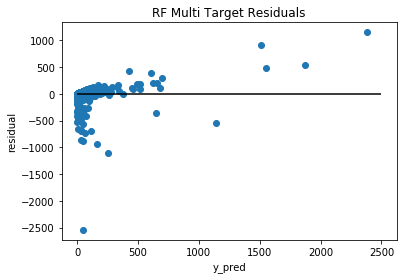

In [290]:
import matplotlib.pyplot as plt

plt.scatter(rf_grid.predict(X_test), rf_grid.predict(X_test) - y_test)
plt.hlines(0,0,2500)
plt.title('RF Multi Target Residuals')
plt.xlabel('y_pred')
plt.ylabel('residual')

In [253]:
### PLOT OF RESIDUALS WITH LOG TRANSFORMATION

Text(0,0.5,'residual')

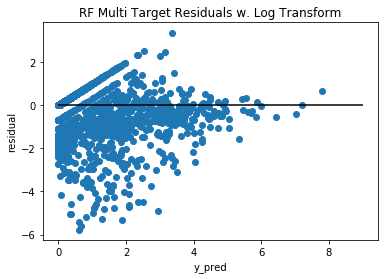

In [256]:
import matplotlib.pyplot as plt

plt.scatter(rf_grid_log.predict(X_test), rf_grid_log.predict(X_test) - log1p(y_test))
plt.hlines(0,0,9)
plt.title('RF Multi Target Residuals w. Log Transform')
plt.xlabel('y_pred')
plt.ylabel('residual')

# Fitting a Ridge Regression

In [89]:
from sklearn.linear_model import Ridge

In [158]:
ridge_estimators = [
    ('scale',StandardScaler()),
    ('model',Ridge())
]

ridge_pipe = Pipeline(ridge_estimators)

ridge_params = {
    'model__alpha':[.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0,2.0],
    'model__solver':['saga']
}

ridge_grid = GridSearchCV(estimator = ridge_pipe, param_grid=ridge_params, cv=5)

In [159]:
ridge_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'model__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0], 'model__solver': ['saga']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [160]:
ridge_grid.best_estimator_

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='saga', tol=0.001))])

In [189]:
ridge_score = ridge_grid.score(X_test, y_test)

# Fitting a Lasso Regression

In [169]:
from sklearn.linear_model import Lasso

lasso_estimators = [
    ('scale',StandardScaler()),
    ('model', Lasso())
]

lasso_pipe = Pipeline(lasso_estimators)

lasso_params = {
    'model__alpha':[.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
}

lasso_grid = GridSearchCV(estimator=lasso_pipe,param_grid=lasso_params, cv=5)

In [267]:
lasso_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'model__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [262]:
lasso_score = lasso_grid.score(X_test, y_test)

In [332]:
all_scores = [gb_score, rf_score, ridge_score, lasso_score]

for score in all_scores:
    print(score)

-0.7672293638565129
0.14299828532287312
0.0936315159981099
0.0880017040369601


# ^ These are the R2s before any transformations... not very strong results. We see (as demonstrated in the RandomForest Regressor section) that the residuals get a bit better when we perform a transformation on the dependent variable. 